In [2]:

import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, Input,Layer
from scipy.fftpack import dct
import torch
# Configurazione per la GPU

torch.cuda.empty_cache()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limita la memoria GPU allocata (opzionale)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Permette allocazione dinamica della memoria
        print(f"{len(gpus)} GPU(s) disponibile/i.")
    except RuntimeError as e:
        print(e)
else:
    print("Nessuna GPU disponibile, verrà usata la CPU.")

# Carica il dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

def apply_dct(data):
    # Esegui la DCT bidimensionale sull'immagine
    # La `type=2` rappresenta la DCT-II, che è la più comune
    return dct(dct(data, axis=0, norm='ortho'), axis=1, norm='ortho')

size=(56,56)

def resize_images(data, target_size):
    # Usa TensorFlow per ridimensionare ogni immagine
    data_resized = tf.image.resize(data[..., tf.newaxis], target_size)
    return data_resized.numpy()

X_train_resized = resize_images(X_train,size)
X_test_resized = resize_images(X_test,size)

X_train_dct = np.array([apply_dct(img) for img in X_train_resized])  # Applica la DCT alle immagini di training
X_test_dct = np.array([apply_dct(img) for img in X_test_resized])  # Applica la DCT alle immagini di test


print("Forma di X_train_dct:", X_train_dct.shape)
print("Forma di X_test_dct:", X_test_dct.shape)

1 GPU(s) disponibile/i.


I0000 00:00:1734771028.688330    4666 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734771028.689643    4666 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734771028.689950    4666 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734771028.961413    4666 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Forma di X_train_dct: (60000, 56, 56, 1)
Forma di X_test_dct: (10000, 56, 56, 1)


In [3]:
filtri = np.random.rand(32, 3, 3)

filtri_dct = np.array([apply_dct(img) for img in filtri])  # Applica la DCT alle immagini di training


# Stampa i filtri generati
for i, filtro in enumerate(filtri_dct):
    print(f"Filtro {i+1}:\n{filtro}\n")

Filtro 1:
[[ 1.35162802  0.4900861  -0.05840587]
 [ 0.1693693  -0.09265262 -0.28820608]
 [ 0.04832287  0.04881288 -0.65821079]]

Filtro 2:
[[ 1.77540741e+00 -3.78384647e-02 -2.75523366e-01]
 [-1.20971187e-01 -1.15269443e-01 -1.98748486e-01]
 [ 4.34242978e-01 -1.03485530e-02  1.14867409e-03]]

Filtro 3:
[[ 1.09655658  0.49297854  0.13344712]
 [ 0.16359954  0.31844681  0.34712393]
 [-0.28877196 -0.4846438   0.11716763]]

Filtro 4:
[[ 0.79646056  0.00214237 -0.30878082]
 [-0.42779868 -0.15589683  0.30076332]
 [ 0.25965632 -0.05260594 -0.3934303 ]]

Filtro 5:
[[ 1.6172815  -0.05238026  0.39756448]
 [ 0.15157538  0.33073817 -0.10620109]
 [ 0.20640357 -0.63675495 -0.15849097]]

Filtro 6:
[[ 1.41840023 -0.12378593 -0.31766594]
 [ 0.38147116  0.04089965  0.06101318]
 [ 0.39954264  0.34690863 -0.28432669]]

Filtro 7:
[[ 1.03957659  0.40219142  0.144539  ]
 [-0.04778256 -0.19362542 -0.34063228]
 [-0.41033196 -0.30520992 -0.0306859 ]]

Filtro 8:
[[ 1.67063158  0.29258043  0.05364908]
 [ 0.8689450

In [4]:
#rimuovi tutte le colonne apparte prime 3 in tutte le immagini di training e test
#X_train_dct = X_train_dct[:, :, :3]
#X_test_dct = X_test_dct[:, :, :3]



#printa le shape

print("Forma di X_train_dct:", X_train_dct.shape)
print("Forma di X_test_dct:", X_test_dct.shape)


Forma di X_train_dct: (60000, 56, 56, 1)
Forma di X_test_dct: (10000, 56, 56, 1)


In [5]:
class IDCTLayer(Layer):
    def __init__(self, **kwargs):
        super(IDCTLayer, self).__init__(**kwargs)

    def call(self, inputs):
        def idct_2d(tensor):
            x = tf.signal.idct(tensor, type=2, norm='ortho', axis=-1)
            x = tf.transpose(x, perm=[0, 1, 3, 2])
            x = tf.signal.idct(x, type=2, norm='ortho', axis=-1)
            x = tf.transpose(x, perm=[0, 1, 3, 2])  # Ritorna alla forma originale
            return x

        # Applica la IDCT batch-wise e canale per canale
        return idct_2d(inputs)

In [6]:
model = Sequential([
    Input(shape=(56,56)),  
    Flatten(),             
    Dense(228, activation='relu'),
    Dense(576, activation='relu'),
    Dense(1152, activation='relu'),
    Reshape((3, 3, 128)),
    IDCTLayer(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

In [7]:
# Compila il modello
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Addestra il modello
history = model.fit(X_train_dct, y_train, epochs=3, batch_size=64, validation_split=0.2)

# Valuta il modello56
test_loss, test_acc = model.evaluate(X_test_dct, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")


KeyboardInterrupt: 

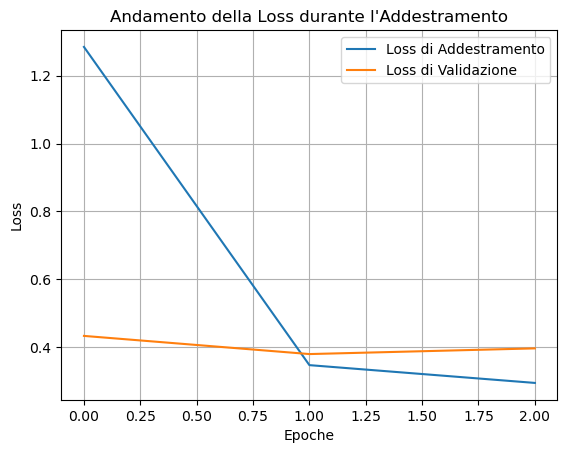

In [ ]:
import matplotlib.pyplot as plt

# Grafico della loss
plt.plot(history.history['loss'], label='Loss di Addestramento')
plt.plot(history.history['val_loss'], label='Loss di Validazione')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Andamento della Loss durante l\'Addestramento')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

# Configurazione per la GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limita la memoria GPU allocata (opzionale)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Permette allocazione dinamica della memoria
        print(f"{len(gpus)} GPU(s) disponibile/i.")
    except RuntimeError as e:
        print(e)
else:
    print("Nessuna GPU disponibile, verrà usata la CPU.")

# Carica il dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
size=(28,28)
def resize_images(data, target_size):
    # Usa TensorFlow per ridimensionare ogni immagine
    data_resized = tf.image.resize(data[..., tf.newaxis], target_size)
    return data_resized.numpy()

X_train_resized = resize_images(X_train,size)
X_test_resized = resize_images(X_test,size)

# Crea il modello
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(size[0],size[1], 1)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


# Compila il modello
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Addestra il modello
history = model.fit(X_train_resized, y_train, epochs=3, batch_size=64, validation_split=0.2)

# Valuta il modello
test_loss, test_acc = model.evaluate(X_test_resized, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")


1 GPU(s) disponibile/i.
Epoch 1/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7891 - loss: 2.5390 - val_accuracy: 0.8694 - val_loss: 0.3489
Epoch 2/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9118 - loss: 0.2420 - val_accuracy: 0.9056 - val_loss: 0.2836
Epoch 3/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9408 - loss: 0.1660 - val_accuracy: 0.8943 - val_loss: 0.3130
313/313 - 1s - 3ms/step - accuracy: 0.8904 - loss: 0.3279
Test accuracy: 0.89


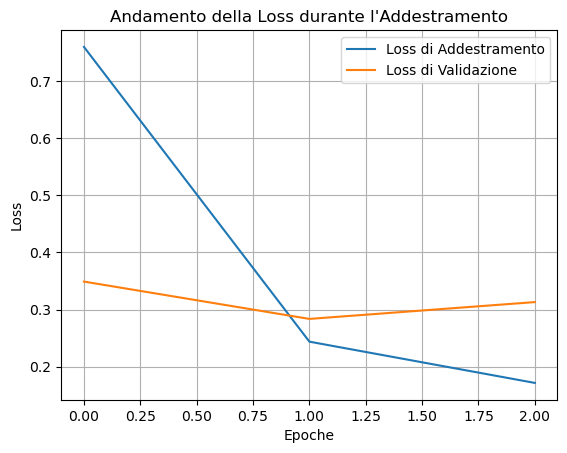

In [ ]:
# Grafico della loss
plt.plot(history.history['loss'], label='Loss di Addestramento')
plt.plot(history.history['val_loss'], label='Loss di Validazione')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Andamento della Loss durante l\'Addestramento')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape,Layer
import tensorflow as tf
import numpy as np

class CustomFilterLayer(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(CustomFilterLayer, self).__init__(**kwargs)
        self.filters = self.add_weight(
            shape=filters.shape,           # Usa la forma dei filtri forniti
            initializer=tf.constant_initializer(filters),  # Inizializza con i tuoi filtri
            trainable=True                 # Rende i filtri addestrabili
        )
    
    def call(self, inputs):
        print("Forma di inputs:", inputs.shape)
        print("Forma dei filtri:", self.filters.shape)
        ciao= tf.matmul( inputs,self.filters)
        print("Forma di ciao:", ciao.shape)
        return ciao

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_dct = np.array([apply_dct(img) for img in X_train])  # Applica la DCT alle immagini di training
X_test_dct = np.array([apply_dct(img) for img in X_test])  # Applica la DCT alle immagini di test
X_train_dct = X_train_dct[:, :, :3]
X_test_dct = X_test_dct[:, :, :3]

#X_train_dct = np.expand_dims(X_train_dct, axis=-1)


#printa le shape
print("Forma di X_train_dct:", X_train_dct.shape)
print("Forma di X_test_dct:", X_test_dct.shape)

#genera i filtri in modo che abbiano 3 altezza,3 larghezza e 32 canali e in greyscale
filtri1 = np.random.rand(3, 3,32)
filtri_dct1 = np.array([apply_dct(img) for img in filtri1])  # Applica la DCT alle immagini di training

filtri2 = np.random.rand(64, 3, 3)
filtri_dct2 = np.array([apply_dct(img) for img in filtri2])  # Applica la DCT alle immagini di training

filtri3 = np.random.rand(1,128, 3, 3)
filtri_dct = np.array([apply_dct(img) for img in filtri3])  # Applica la DCT alle immagini di training

# Stampa le forme dei filtri
print("Forma dei filtri1:", filtri1.shape)

# Costruzione del modello
model = Sequential([
    Input(shape=(28, 3)),  # Input di dimensione 56x56
    CustomFilterLayer(filters=filtri1),  # Primo layer personalizzato
    #CustomFilterLayer(filters=filtri2),  # Primo layer personalizzato


# Layer finale per la classificazione
])

# Sommario del modello
model.summary()


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Addestra il modello
history = model.fit(X_train_dct, y_train, epochs=3, batch_size=32, validation_split=0.2)

# Valuta il modello
test_loss, test_acc = model.evaluate(X_test_dct, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

Forma di X_train_dct: (60000, 28, 3)
Forma di X_test_dct: (10000, 28, 3)
Forma dei filtri1: (3, 3, 32)
Forma di inputs: (None, 28, 3)
Forma dei filtri: (3, 3, 32)
Forma di ciao: (3, 28, 32)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_filter_layer_53          │ (3, 28, 32)            │           288 │
│ (CustomFilterLayer)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288 (1.12 KB)

 Trainable params: 288 (1.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
Forma di inputs: (32, 28, 3)
Forma dei filtri: (3, 3, 32)


ValueError: Exception encountered when calling CustomFilterLayer.call().

[1mDimensions must be equal, but are 32 and 3 for '{{node sequential_39_1/custom_filter_layer_53_1/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false, grad_x=false, grad_y=false](data, sequential_39_1/custom_filter_layer_53_1/MatMul/ReadVariableOp)' with input shapes: [32,28,3], [3,3,32].[0m

Arguments received by CustomFilterLayer.call():
  • inputs=tf.Tensor(shape=(32, 28, 3), dtype=float32)

In [43]:
import numpy as np

# Definisci una matrice 3D (A) di dimensioni (m, n, p)
A = np.random.rand(2, 3, 4)  # Matrice 3D di dimensioni 2x3x4

# Definisci una matrice 2D (B) di dimensioni (n, q)
B = np.random.rand(3, 2)  # Matrice 2D di dimensioni 3x2

# Inizializza la matrice risultante C di dimensioni (m, q, p)
m, n, p = A.shape
q = B.shape[1]
C = np.zeros((m, q, p))

# Moltiplicazione utilizzando np.matmul
for k in range(p):  # Per ogni "strato" di A
    C[:, :, k] = np.matmul(A[:, :, k], B)  # Prodotto matrice-matrice tra A[:, :, k] e B

# Mostra il risultato
print("Matrice 3D A (dimensioni 2x3x4):")
print(A)
print("\nMatrice 2D B (dimensioni 3x2):")
print(B)
print("\nMatrice 3D risultante C (dimensioni 2x2x4):")
print(C)

Matrice 3D A (dimensioni 2x3x4):
[[[0.54191156 0.24761614 0.99081395 0.57582617]
  [0.89639119 0.38215769 0.58650983 0.0062246 ]
  [0.64502898 0.59711582 0.46861482 0.23241527]]

 [[0.74456989 0.23392199 0.5212829  0.0327434 ]
  [0.47673436 0.25026192 0.04827552 0.15980057]
  [0.32916242 0.08184919 0.53480181 0.07935704]]]

Matrice 2D B (dimensioni 3x2):
[[0.34666779 0.85650259]
 [0.16093226 0.89945225]
 [0.32948863 0.95559487]]

Matrice 3D risultante C (dimensioni 2x2x4):
[[[0.54465126 0.34408491 0.59227489 0.27720031]
  [1.88679611 1.12641727 1.82397821 0.72089017]]

 [[0.44329561 0.14833681 0.36469219 0.06321539]
  [1.38107176 0.5036681  1.00095554 0.24761097]]]
